# Airbnb Berlin Price Prediction

This is a Kaggle competition and can be found [here](https://www.kaggle.com/datasets/gauravduttakiit/airbnb-berlin-price-prediction)

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from joblib import dump
import pickle

# Define functions

In [2]:
def print_best_model_metrics(gs, X, y):
    """"
    gs: fitted GridSearch object
    X: DataFrame with features
    y: actual target
    """
    print(f"Best parameters:\n{gs.best_params_}")
    print(f"\nBest score: {gs.best_score_:.3f}")
    print(f"RMSE: {np.sqrt(-1*gs.best_score_):.3f}")
    score = gs.score(X, y)
    print(f"\nneg_mean_squared_error on the full train set: {score:.3f}")
    print(f"RMSE on the full train set: {np.sqrt(-1*score):.3f}")
    y_pred = gs.predict(X)
    print(f"\nMean squared error on the full train set = {mean_squared_error(y, y_pred, squared=False):.2f}")

# Load data

In [3]:
# Load the dataset
def load_ds(path: Path, filename: str) -> pd.DataFrame:
    """Read the dataset csv file as a pandas dataframe."""
    return pd.read_csv(path / filename)

# Load dataset
dataset_path = Path().absolute() / "data"
filename = "X_y_train.csv"
X_y_train = load_ds(dataset_path, filename)

print(f"Shape: {X_y_train.shape}")

Shape: (11243, 39)


In [4]:
X_y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11243 entries, 0 to 11242
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Listing ID             11242 non-null  float64
 1   Listing Name           11197 non-null  object 
 2   Host ID                11243 non-null  float64
 3   Host Name              11229 non-null  object 
 4   Host Since             11230 non-null  object 
 5   Host Response Time     6133 non-null   object 
 6   Host Response Rate     6133 non-null   object 
 7   Is Superhost           11228 non-null  object 
 8   neighbourhood          11243 non-null  object 
 9   Neighborhood Group     11243 non-null  object 
 10  City                   11242 non-null  object 
 11  Postal Code            11074 non-null  object 
 12  Country Code           11243 non-null  object 
 13  Country                11243 non-null  object 
 14  Latitude               11243 non-null  float64
 15  Lo

In [5]:
y_train = X_y_train.loc[:, "Price"].copy()
X_train = X_y_train.drop(columns="Price")

In [6]:
X_train.columns

Index(['Listing ID', 'Listing Name', 'Host ID', 'Host Name', 'Host Since',
       'Host Response Time', 'Host Response Rate', 'Is Superhost',
       'neighbourhood', 'Neighborhood Group', 'City', 'Postal Code',
       'Country Code', 'Country', 'Latitude', 'Longitude', 'Is Exact Location',
       'Property Type', 'Room Type', 'Accomodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Square Feet', 'Guests Included', 'Min Nights', 'Reviews',
       'First Review', 'Last Review', 'Overall Rating', 'Accuracy Rating',
       'Cleanliness Rating', 'Checkin Rating', 'Communication Rating',
       'Location Rating', 'Value Rating', 'Instant Bookable',
       'Business Travel Ready'],
      dtype='object')

# Preprocessing pipeline

In [7]:
# TransformerMixin: add method ".fit_transform()"
# BaseEstimator: add methods ".get_params()" and ".set_params()"
# We need 3 methods:
# 1) .fit()
# 2) .transform()
# 3) .fit_transform() (provided by "TransformerMixin")
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    # avoid "*args" or "**kargs" in "__init__"
    def __init__(self):
        pass

    # fit is needed later for the pipilene
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):

        # tranformen data frame
        X_tran = pd.DataFrame()

        # Host Since
        date = pd.to_datetime(X["Host Since"], format="%Y-%m-%d")
        X_tran["year"] = date.dt.year

        # Is Superhost
        X_tran["Is Superhost"] = X["Is Superhost"]

        # Property Type
        X_tran["Property Type"] = X["Property Type"]
        X_tran.loc[X["Property Type"] == "*", "Property Type"] = np.nan

        # Room Type
        X_tran["Room Type"] = X["Room Type"]

        # Accomodates
        X_tran["Accomodates"] = X["Accomodates"]
        X_tran.loc[X_tran.Accomodates == "*", "Accomodates"] = np.nan
        X_tran["Accomodates"] = X_tran.Accomodates.astype("float")

        # Bathrooms
        X_tran["Bathrooms"] = X["Bathrooms"]
        X_tran.loc[X_tran.Bathrooms == "*", "Bathrooms"] = np.nan
        X_tran["Bathrooms"] = X_tran.Bathrooms.astype("float")

        # Bedrooms
        X_tran["Bedrooms"] = X["Bedrooms"]
        X_tran.loc[X_tran.Bedrooms == "*", "Bedrooms"] = np.nan
        X_tran["Bedrooms"] = X_tran.Bedrooms.astype("float")

        # Beds
        X_tran["Beds"] = X["Beds"]
        X_tran.loc[X_tran.Beds == "*", "Beds"] = np.nan
        X_tran["Beds"] = X_tran.Beds.astype("float")

        # Min Nights
        X_tran["Min Nights"] = X["Min Nights"]
        X_tran.loc[X_tran["Min Nights"] == "*", "Min Nights"] = np.nan
        X_tran["Min Nights"] = X_tran["Min Nights"].astype("float")

        # Instant Bookable
        X_tran["Instant Bookable"] = X["Instant Bookable"]

        return X_tran
     

In [8]:
caa = CombinedAttributesAdder()
X_tmp = X_train.copy()
new_x = caa.fit_transform(X_train)
new_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11243 entries, 0 to 11242
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              11230 non-null  float64
 1   Is Superhost      11228 non-null  object 
 2   Property Type     11195 non-null  object 
 3   Room Type         11243 non-null  object 
 4   Accomodates       11237 non-null  float64
 5   Bathrooms         11227 non-null  float64
 6   Bedrooms          11237 non-null  float64
 7   Beds              11236 non-null  float64
 8   Min Nights        11058 non-null  float64
 9   Instant Bookable  11243 non-null  object 
dtypes: float64(6), object(4)
memory usage: 878.5+ KB


In [9]:
(new_x.isna().sum() / new_x.shape[0]).reset_index()

,index,0
0,year,0.001156
1,Is Superhost,0.001334
2,Property Type,0.004269
3,Room Type,0.000000
4,Accomodates,0.000534
5,Bathrooms,0.001423
6,Bedrooms,0.000534
7,Beds,0.000623
8,Min Nights,0.016455
9,Instant Bookable,0.000000


In [10]:
# Numerical pipeline
#
# All (except the last) estimators must be transformers (i.e., they
# must have a ".fit_transform()" method).
num_pipeline = Pipeline([
    # replace NA with mean
    ('imputer', SimpleImputer(strategy='mean')),
    # standardize the variables: z = (x - mean) / SD
    ('std_scaler', StandardScaler())])

In [11]:
# Categorical pipeline
#
# All (except the last) estimators must be transformers (i.e., they
# must have a ".fit_transform()" method).
cat_pipeline = Pipeline([
    # replace NA with mode
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # apply "OneHotEncoder()"
    ('one_hot', OneHotEncoder(drop='if_binary'))])

In [12]:
list_num_attribs = ["Accomodates", "Bathrooms", "Bedrooms", "Beds",
                    "Min Nights", "year"]
list_cat_attribs = ["Is Superhost", "Property Type", "Room Type", "Instant Bookable"]

In [13]:
# ColumnTransformer requires tuples with:
# - a name
# - a transformer
# - a list of names (or indices) of columns to which the transformer is applied

cols_transformer = ColumnTransformer([
    # apply "num_pipeline" to numerical columns
    ('num', num_pipeline, list_num_attribs),
    # apply "cat_pipeline" to categorical columns
    ('cat', cat_pipeline, list_cat_attribs)])

In [14]:
full_pipeline = Pipeline([
    # transform/add columns
    ('attribs_adder', CombinedAttributesAdder()),
    # Transform numerical and categorical attributes
    ("cols_transformer", cols_transformer)])

In [15]:
full_pipeline_tmp = Pipeline([
    # transform/add columns
    ('attribs_adder', CombinedAttributesAdder()),
    # Transform numerical and categorical attributes
    ("cols_transformer", cols_transformer)])

X_tmp = X_train.copy()
new_x = full_pipeline_tmp.fit_transform(X_tmp)
new_x.shape

(11243, 26)

# Random Forest

In [16]:
rf = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # Random forest
    ("rf", RandomForestRegressor(max_depth= 20, min_samples_leaf=30, random_state=123))])

In [17]:
rf.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 Pipeline(steps=[('attribs_adder', CombinedAttributesAdder()),
                                 ('cols_transformer',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('std_scaler',
                                                                                    StandardScaler())]),
                                                                   ['Accomodates',
                                                                    'Bathrooms',
                                                                    'Bedrooms',
                                                                    'Beds',
                                                                    'Min '
                                                                    'Nights',
                                                                    'year']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('one_hot',
                                                                                    OneHotEncoder(drop='if_binary'))]),
                                                                   ['Is '
                                                                    'Superhost',
                                                                    'Property '
                                                                    'Type',
                                                                    'Room Type',
                                                                    'Instant '
                                                                    'Bookable'])]))])),
                ('rf',
                 RandomForestRegressor(max_depth=20, min_samples_leaf=30,
                                       random_state=123))])

In [18]:
rf.score(X_train, y_train)

0.42449828129009237

In [19]:
y_pred_rf = rf.predict(X_train)
mean_squared_error(y_train, y_pred_rf, squared=False)

20.088303051945516

In [20]:
np.sqrt(np.sum((y_train -y_pred_rf)**2) / len(y_train))

20.088303051945516

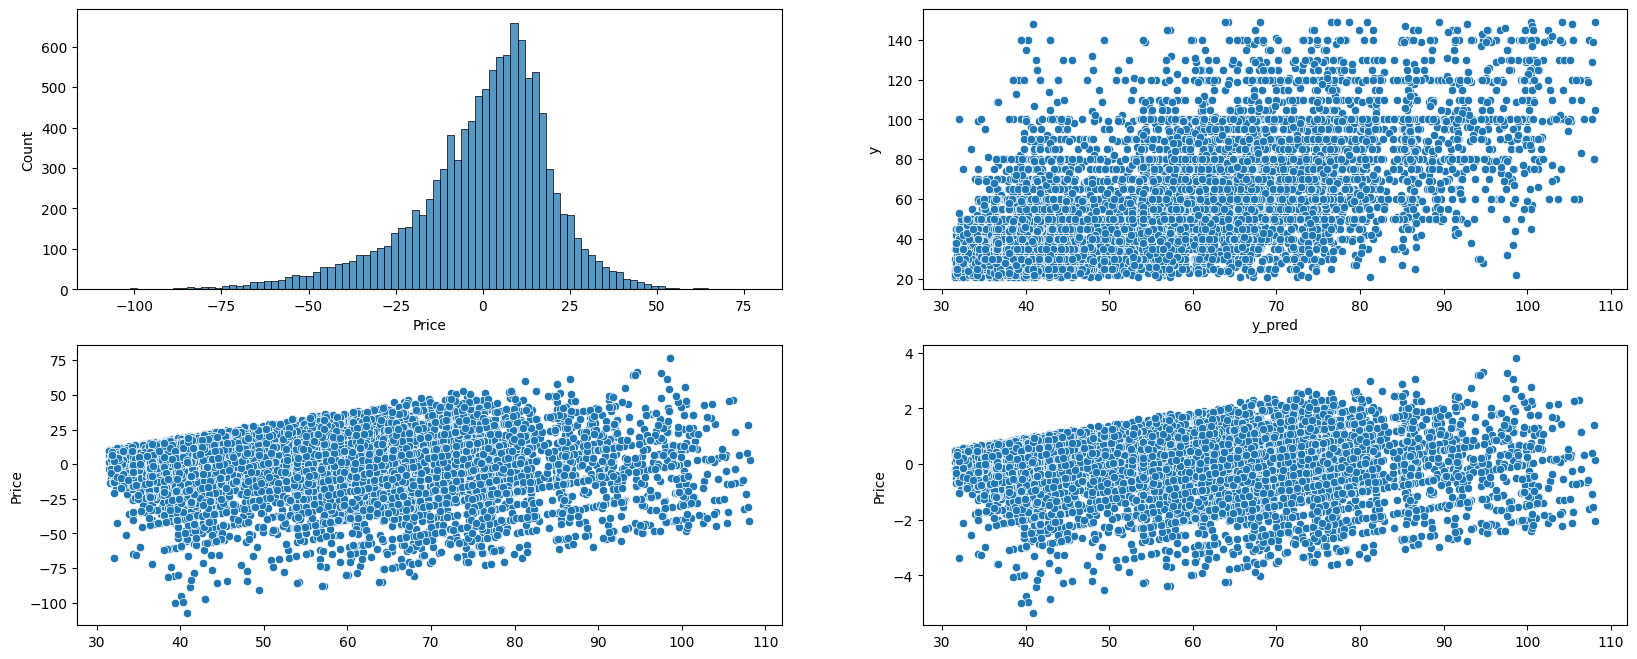

In [21]:
res = (y_pred_rf - y_train)
res_normed = (res - np.mean(res))/np.std(res)

plt.figure(figsize=(20, 8))

plt.subplot(2, 2, 1)
sns.histplot(x=res)

plt.subplot(2, 2, 2)
# sns.histplot(x=res_2)
sns.scatterplot(x=y_pred_rf, y=y_train)
plt.xlabel("y_pred")
plt.ylabel("y")

plt.subplot(2, 2, 3)
sns.scatterplot(x=y_pred_rf, y=res)

plt.subplot(2, 2, 4)
sns.scatterplot(x=y_pred_rf, y=res_normed)

plt.show()

## Cross validation

In [22]:
rf_2 = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # Decision Tree (defaul parameters)
    ("rf", RandomForestRegressor(random_state=123))])

In [23]:
cross_val_score(rf_2, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)

array([-22.39392537, -22.40686123, -22.11246402, -22.83716409,
       -22.95512422])

## Grid Search

In [24]:
rf_3 = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # Decision Tree (defaul parameters)
    ("rf", RandomForestRegressor(random_state=123))])

In [25]:
list(rf_3["rf"].get_params().keys())

['bootstrap',
 'ccp_alpha',
 'criterion',
 'max_depth',
 'max_features',
 'max_leaf_nodes',
 'max_samples',
 'min_impurity_decrease',
 'min_samples_leaf',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'n_estimators',
 'n_jobs',
 'oob_score',
 'random_state',
 'verbose',
 'warm_start']

In [26]:
param_grid = {
    "rf__n_estimators": [100, 150, 200],
    "rf__max_depth": [3, 5, 10],
    "rf__min_samples_leaf": [20, 50]}

rf_gs = GridSearchCV(
    estimator=rf_3,
    param_grid=param_grid,
    cv=5, # train across 5 folds
    scoring='neg_mean_squared_error',
    verbose=1)

The following fitting takes about one minute

In [27]:
rf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preparation',
                                        Pipeline(steps=[('attribs_adder',
                                                         CombinedAttributesAdder()),
                                                        ('cols_transformer',
                                                         ColumnTransformer(transformers=[('num',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer()),
                                                                                                          ('std_scaler',
                                                                                                           StandardScaler())]),
                                                                                          ['Accomodates',
                                                                                           'Bathrooms',
                                                                                           'Bedrooms',
                                                                                           'Beds',
                                                                                           'Min '
                                                                                           'Nights',
                                                                                           'year']),
                                                                                         ('cat',
                                                                                          Pipeline(steps=[('i...
                                                                                                           SimpleImputer(strategy='most_frequent')),
                                                                                                          ('one_hot',
                                                                                                           OneHotEncoder(drop='if_binary'))]),
                                                                                          ['Is '
                                                                                           'Superhost',
                                                                                           'Property '
                                                                                           'Type',
                                                                                           'Room '
                                                                                           'Type',
                                                                                           'Instant '
                                                                                           'Bookable'])]))])),
                                       ('rf',
                                        RandomForestRegressor(random_state=123))]),
             param_grid={'rf__max_depth': [3, 5, 10],
                         'rf__min_samples_leaf': [20, 50],
                         'rf__n_estimators': [100, 150, 200]},
             scoring='neg_mean_squared_error', verbose=1)

In [28]:
print_best_model_metrics(rf_gs, X_train, y_train)

Best parameters:
{'rf__max_depth': 10, 'rf__min_samples_leaf': 20, 'rf__n_estimators': 200}

Best score: -428.810
RMSE: 20.708

neg_mean_squared_error on the full train set: -399.657
RMSE on the full train set: 19.991

Mean squared error on the full train set = 19.99


# Retrain final model

Retrain the model on the full train set

In [29]:
final_model = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # Decision Tree (defaul parameters)
    ("rf", RandomForestRegressor(max_depth=10, min_samples_leaf=20, n_estimators=150, random_state=123))])

In [30]:
final_model.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 Pipeline(steps=[('attribs_adder', CombinedAttributesAdder()),
                                 ('cols_transformer',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('std_scaler',
                                                                                    StandardScaler())]),
                                                                   ['Accomodates',
                                                                    'Bathrooms',
                                                                    'Bedrooms',
                                                                    'Beds',
                                                                    'Min '
                                                                    'Nights',
                                                                    'year']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('one_hot',
                                                                                    OneHotEncoder(drop='if_binary'))]),
                                                                   ['Is '
                                                                    'Superhost',
                                                                    'Property '
                                                                    'Type',
                                                                    'Room Type',
                                                                    'Instant '
                                                                    'Bookable'])]))])),
                ('rf',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=20,
                                       n_estimators=150, random_state=123))])

In [31]:
final_model.score(X_train, y_train)

0.4298848786015208

In [32]:
y_pred_fm = final_model.predict(X_train)
mean_squared_error(y_train, y_pred_fm, squared=False)

19.99407049906083

In [33]:
# manually check RMSE
np.sqrt(np.sum((y_train -y_pred_fm)**2) / len(y_train))

19.99407049906083

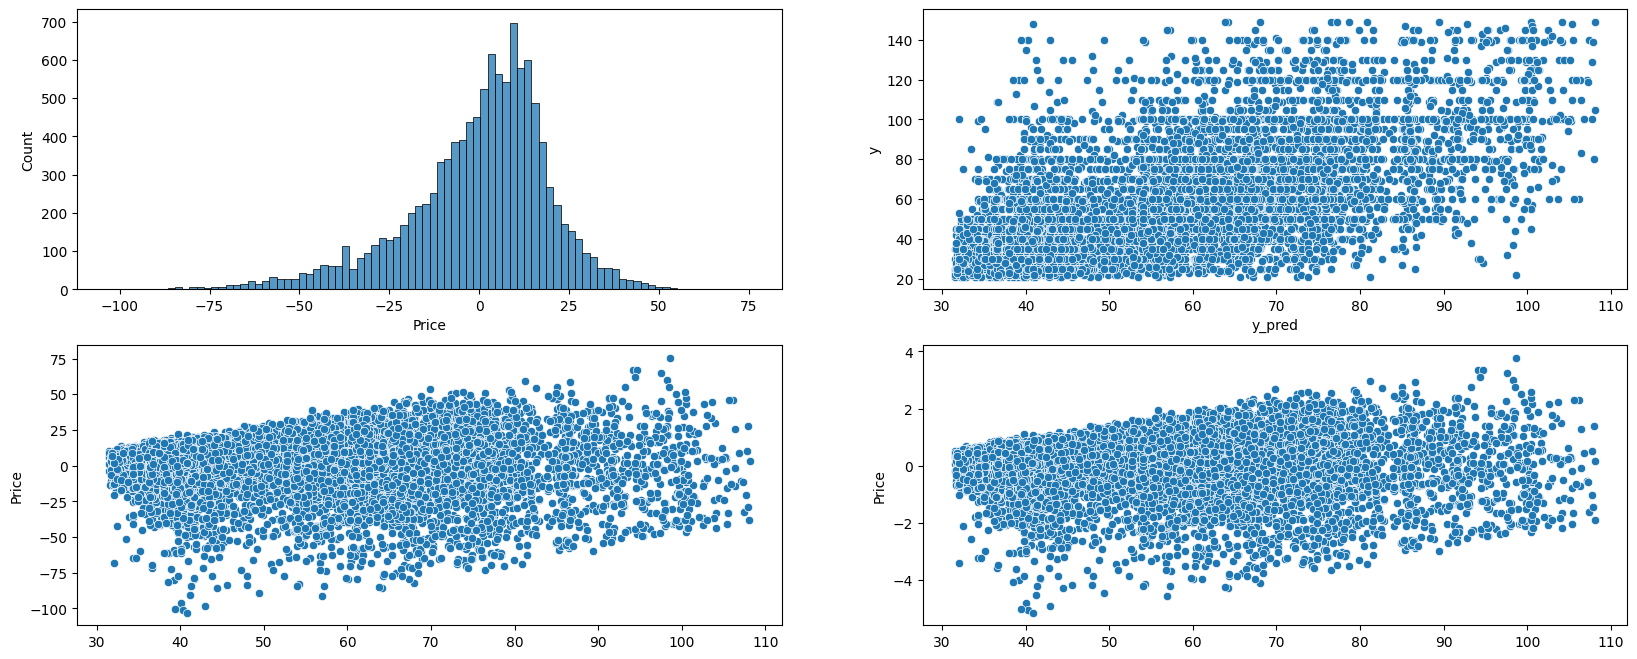

In [34]:
res = (y_pred_fm - y_train)
res_normed = (res - np.mean(res))/np.std(res)

plt.figure(figsize=(20, 8))

plt.subplot(2, 2, 1)
sns.histplot(x=res)

plt.subplot(2, 2, 2)
sns.scatterplot(x=y_pred_rf, y=y_train)
plt.xlabel("y_pred")
plt.ylabel("y")

plt.subplot(2, 2, 3)
sns.scatterplot(x=y_pred_rf, y=res)

plt.subplot(2, 2, 4)
sns.scatterplot(x=y_pred_rf, y=res_normed)

plt.show()

# Test set

In [35]:
# Load dataset
dataset_path = Path().absolute() / "data"
filename = "X_y_test.csv"
X_y_test = load_ds(dataset_path, filename)

print(f"Shape: {X_y_test.shape}")

X_test = X_y_test.drop(["Price"], axis=1)
y_test = X_y_test.loc[:, "Price"].copy()

print(f"shape X_test: {X_test.shape}")
print(f"shape y_test: {y_test.shape}")

Shape: (2811, 39)
shape X_test: (2811, 38)
shape y_test: (2811,)


In [36]:
y_pred_test = final_model.predict(X_test)
mean_squared_error(y_test, y_pred_test, squared=False)

21.41038728040687

In [37]:
mean_absolute_error(y_test, y_pred_test)

15.955482675623792

# Save model

In [38]:
# open a file, where you ant to store the data
file = open('models/final_model.pkl', 'wb')

# dump information to that file
pickle.dump(final_model, file)

# close the file
file.close()